<h1>Modelo de regressão linear para previsão de preços de imóveis</h1>

## Conhecendo o dataset
<hr>

### Descrição:
<p style='line-height: 1.5; text-align: justify;'>O mercado imobiliário vem sendo objeto de diversos estudos e pesquisas nos últimos tempos. A crise financeira que afeta a economia tem afetado significativamente os investimentos e ganhos advindos deste setor. Este cenário incentiva o aumento do interesse por estudos de previsão de demanda baseados em características deste mercado, dos imóveis e do entorno destes imóveis.</p>

<p style='line-height: 1.5; text-align: justify;'>Neste contexto o objetivo principal do nosso projeto é desenvolver um sistema de avaliação imobiliária utilizando a metodologia de regressões lineares que é uma das técnicas de machine learning.</p>

<p style='line-height: 1.5;; text-align: justify;'>Nosso dataset é uma amostra aleatória de tamanho 5000 de imóveis disponíveis para venda no município do Rio de Janeiro.</p>

### Dados:
<ul style='line-height: 1.5; text-align: justify;'>
    <li><b>Valor</b> - Valor (R$) de oferta do imóvel</li>
    <li><b>Area</b> - Área do imóvel em m²</li>
    <li><b>Dist_Praia</b> - Distância do imóvel até a praia (km) (em linha reta)</li>
    <li><b>Dist_Farmacia</b> - Distância do imóvel até a farmácia mais próxima (km) (em linha reta)</li>
</ul>

### Importando bibliotecas

## Leitura dos dados

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics

seed = 100

pd.set_option('display.max_columns', None)

### Funções

In [19]:
# Calcula a quantidade e o percentual de possíveis outliers de uma variável
# Recebe como parâmetro a variável de referência e retorna quantidade e percentual de outliers

def outliers(variavel):
    Q1 = variavel.quantile(.25)
    Q3 = variavel.quantile(.75)
    IIQ = Q3 - Q1
    limite_inferior = Q1 - 1.5*IIQ
    limite_superior = Q1 + 1.5*IIQ

    quantidade = len(variavel[variavel > limite_superior]) + len(variavel[variavel < limite_inferior])
    percentual = quantidade / len(variavel) * 100

    return quantidade, percentual

In [2]:
dados = pd.read_csv('dataset.csv', sep=';')

### Visualizar os dados

In [3]:
dados.head()

,Valor,Area,Dist_Praia,Dist_Farmacia
0,4600000,280,0.240925,0.793637
1,900000,208,0.904136,0.134494
2,2550000,170,0.059525,0.423318
3,550000,100,2.883181,0.525064
4,2200000,164,0.239758,0.192374


### Verificando o tamanho do dataset

In [4]:
dados.shape

(5000, 4)

### Verificando a presença de valores missing

In [69]:
dados.isnull().sum()

Valor            0
Area             0
Dist_Praia       0
Dist_Farmacia    0
dtype: int64

### Verificando o resumo do dataset

In [70]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Valor          5000 non-null   int64  
 1   Area           5000 non-null   int64  
 2   Dist_Praia     5000 non-null   float64
 3   Dist_Farmacia  5000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 156.4 KB


## AnáliseExplorat
<hr style='border: 2px soli;'>

### Estatísticas descritivas

In [5]:
dados.describe().round(2)

,Valor,Area,Dist_Praia,Dist_Farmacia
count,5000.00,5000.00,5000.00,5000.00
mean,1402926.39,121.94,3.02,0.50
std,1883268.85,90.54,3.17,0.29
min,75000.00,16.00,0.00,0.00
25%,460000.00,70.00,0.44,0.24
50%,820000.00,93.00,1.48,0.50
75%,1590000.00,146.00,5.61,0.75
max,25000000.00,2000.00,17.96,1.00


### Matriz de correlação

<p>O <b>coeficiente de correlação</b> é uma medida de associação linear entre duas variáveis e situa-se entre <b>-1</b> e <b>+1</b> sendo que <b>-1</b> indica associação negativa perfeita e <b>+1</b> indica associação positiva perfeita.</p>

<Axes: >

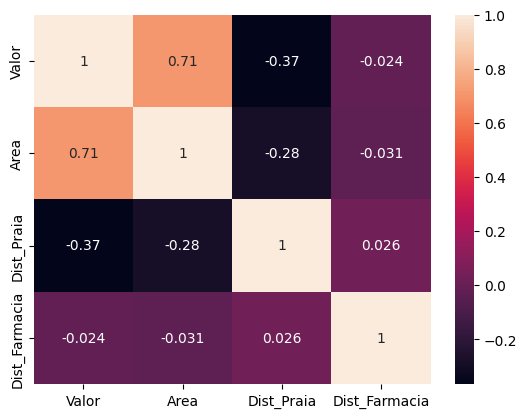

In [7]:
sns.heatmap(dados.corr().round(4), annot=True)

As variáveis que apresentam maior correlação com a variável target(Valor) são as variáveis Area e Dist_Praia, sendo Area a mais forte.

Nota-se também que as variáveiArea e Dist_Praia têm baixa correlação entre si. Isso é bom para a generalização do modelo.te

### Box plot das variáveis

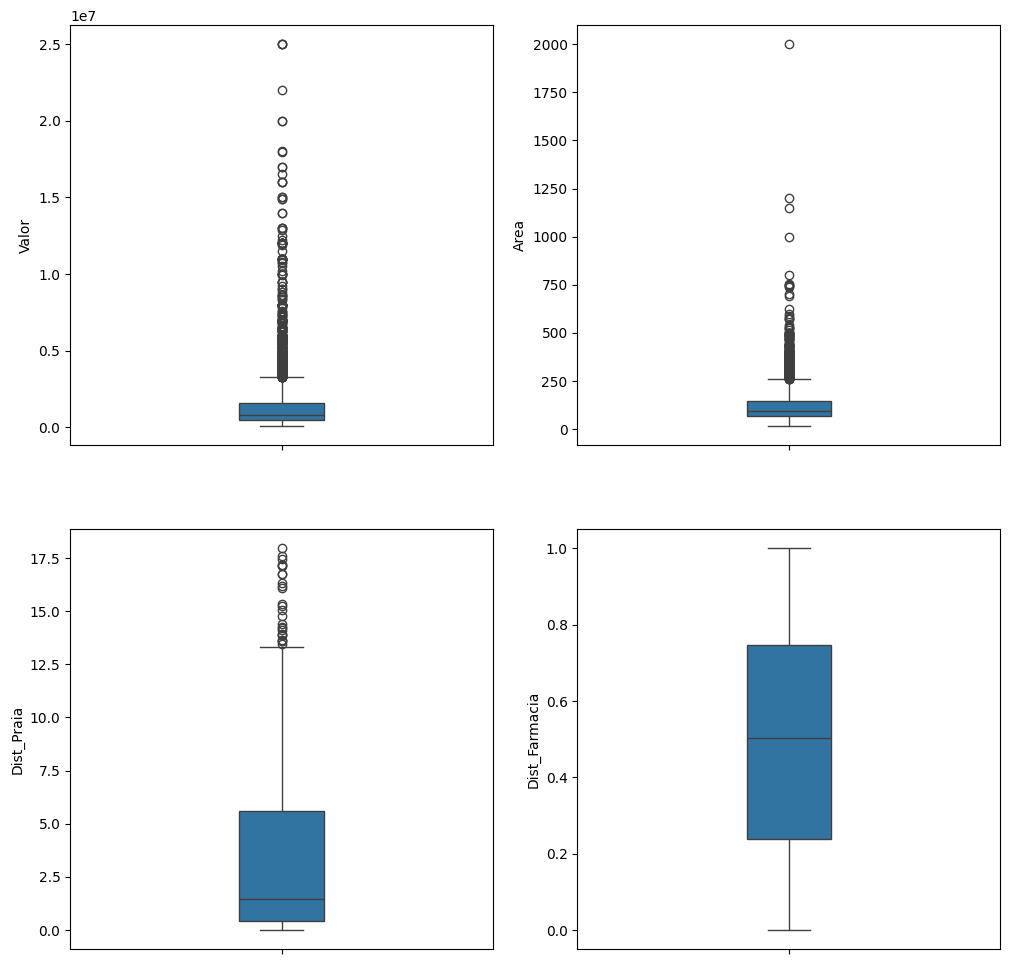

In [65]:
_,axes = plt.subplots(2,2, figsize=(12,12))

line = 0
col = 0

for i in dados.columns[:]:
    ax = sns.boxplot(data=dados[i], orient='v', width=0.2, ax=axes[line,col])
    col+=1
    if col > 1:
        col = 0
        line+=1

Analisando o gráfico acima, percebemos que existe uma grande quantidade de possíveis outliers. Vamos verificar abaixo o percentual de possíveis outliers

In [64]:
for i in dados.columns[:]:
    print(f'Existem {outliers(dados[i])[0]} possíveis outliers na variável {i}. \nIsso representa {outliers(dados[i])[1]:.2f}% do total de casos.\n')

Existem 825 possíveis outliers na variável Valor. 
Isso representa 16.50% do total de casos.

Existem 783 possíveis outliers na variável Area. 
Isso representa 15.66% do total de casos.

Existem 334 possíveis outliers na variável Dist_Praia. 
Isso representa 6.68% do total de casos.

Existem 0 possíveis outliers na variável Dist_Farmacia. 
Isso representa 0.00% do total de casos.



Podemos notar que todas as variáveis, com excessão da variável Dist_Praia, apresentaram possíveis outliers. Como os percentuais são relativamente baixo, não sabemos a origem dos dados e por não possuir nenhum método para confirmar a fidedignidade destes, iremos mantê-los originais, sem nenhum tratamento.

## Configurações de formatação dos gráficos

In [ ]:
# palette -> Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

# style -> white, dark, whitegrid, darkgrid, ticks


### Distribuição de frequências da variável target

<Axes: title={'center': 'Distribuição de Frequências'}, xlabel='Valores dos Imóveis (R$)', ylabel='Quantidade'>

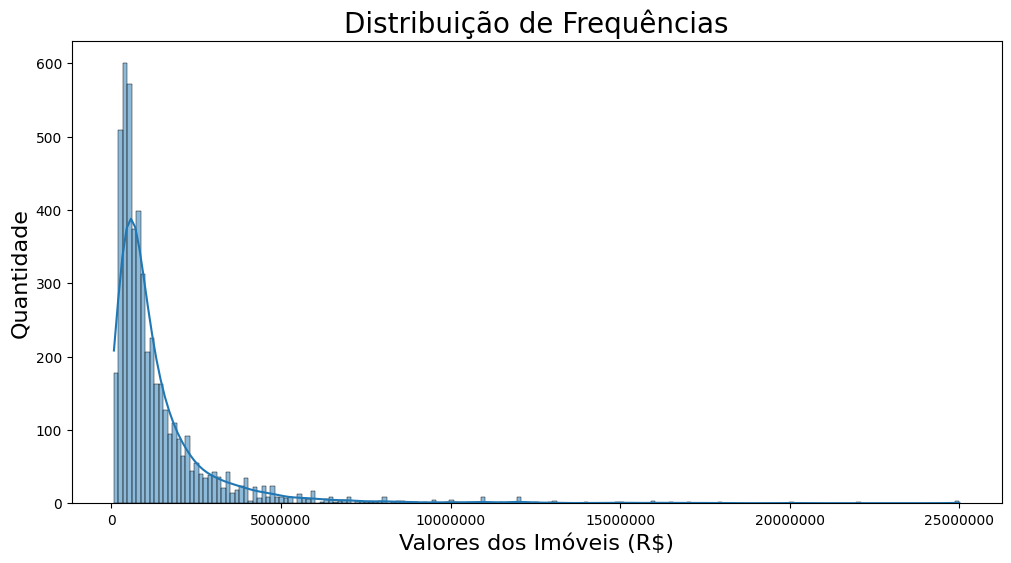

In [35]:
_,ax = plt.subplots(figsize=(12,6))
ax= sns.histplot(dados['Valor'], kde=True)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_xlabel('Valores dos Imóveis (R$)', fontsize=16)
ax.set_ylabel('Quantidade', fontsize=16)
ax.ticklabel_format(style='plain', axis='both')
ax

Nota-se que a variável target não apresenta uma distribuição normal, mas sim uma distribuição assimétrica à direita. Verificaremos as outras variáveis e, se necessário trataremos os dados para tentar obter uma distribuição mais próxima de uma normal.

### Dispersão entre as variáveis do dataset

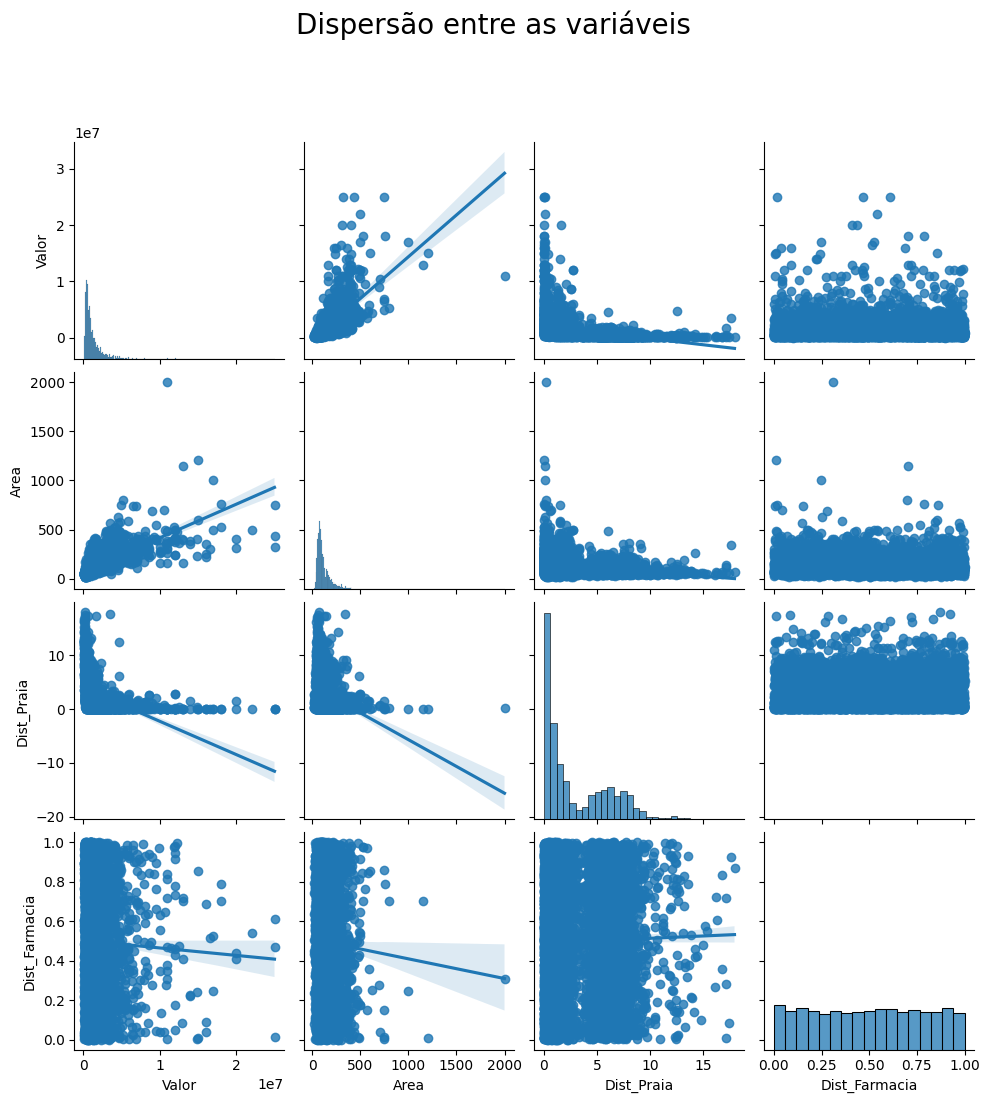

In [41]:
ax= sns.pairplot(dados, kind='reg')
ax.fig.suptitle('Dispersão entre as variáveis', fontsize=20, y=1.1)
ax

Nota-se, como mencionado anteriormente, que a variável Area apresenta maior correlação com a variável Valor. As outras variáveis apresentam baixa correlação, dificultando a interpretação destas pelos seus respectivos gráficos.

É possivel notar também que nenhuma das variáveis apresenta distribuição normal. Em virtude disso, iremos fazer uma ransformação logarítmica nas variáveis na seção abaixo.

### Transformação logarítmica dos dados

Testes paramétricos assumem que os dados amostrais foram coletados de uma população com distribuição de probabilidade conhecida. Boa parte dos testes estatísticos assumem que os dados seguem uma distribuição normal (t de Student, intervalos de confiança etc.)

In [43]:
dados_log = pd.DataFrame()

In [45]:
dados.describe().round(2)

,Valor,Area,Dist_Praia,Dist_Farmacia
count,5000.00,5000.00,5000.00,5000.00
mean,1402926.39,121.94,3.02,0.50
std,1883268.85,90.54,3.17,0.29
min,75000.00,16.00,0.00,0.00
25%,460000.00,70.00,0.44,0.24
50%,820000.00,93.00,1.48,0.50
75%,1590000.00,146.00,5.61,0.75
max,25000000.00,2000.00,17.96,1.00


In [47]:
dados_log['Valor'] = np.log(dados['Valor'])
dados_log['Area'] = np.log(dados['Area'])
dados_log['Dist_Praia'] = np.log(dados['Dist_Praia'] + 1)
dados_log['Dist_Farmacia'] = np.log(dados['Dist_Farmacia'] + 1)

In [48]:
dados_log.head()

,Valor,Area,Dist_Praia,Dist_Farmacia
0,15.341567,5.634790,0.215857,0.584245
1,13.710150,5.337538,0.644028,0.126187
2,14.751604,5.135798,0.057821,0.352991
3,13.217674,4.605170,1.356655,0.422036
4,14.603968,5.099866,0.214916,0.175946


### Distribuição de frequências da variável target transformada

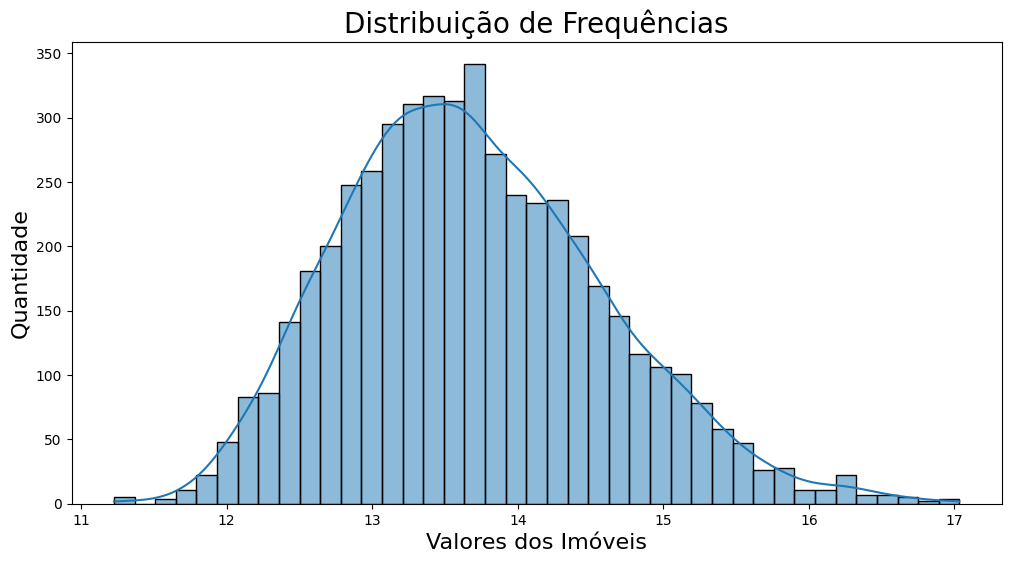

In [50]:
_,ax = plt.subplots(figsize=(12,6))
ax= sns.histplot(dados_log['Valor'], kde=True)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_xlabel('Valores dos Imóveis', fontsize=16)
ax.set_ylabel('Quantidade', fontsize=16)
ax.ticklabel_format(style='plain', axis='both')

Nota-se que, com a transformação, a variável target ficou com distribuição praticamente normal.

### Dispersão entre as variáveis transformadas

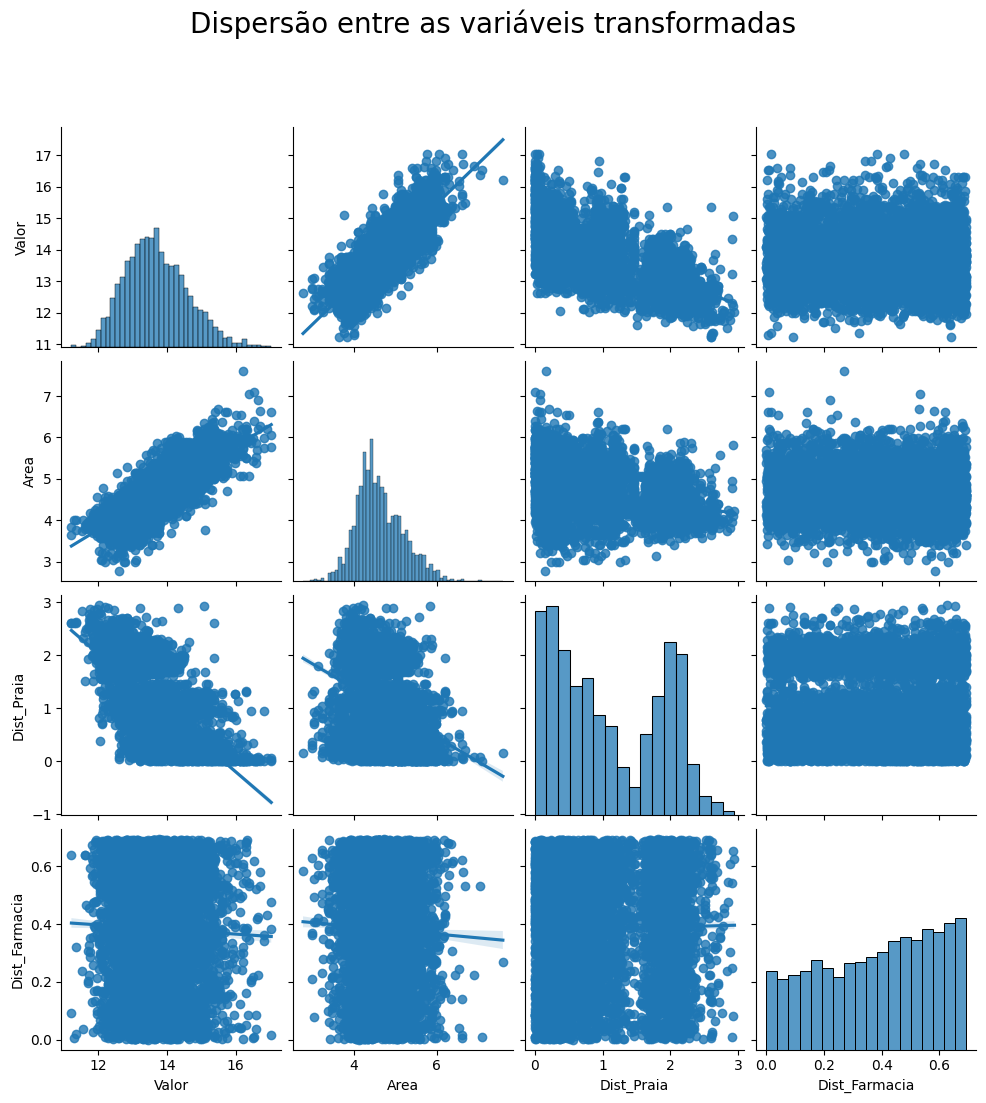

In [51]:
ax= sns.pairplot(dados_log, kind='reg')
ax.fig.suptitle('Dispersão entre as variáveis transformadas', fontsize=20, y=1.1)
ax

Podemos notar, com o auxílio do gráfico acima, que as distribuições das variáveis Valor e Area melhoraram muito, fato esse que não se fez presente nas demasi variáveis.

Nota-se também que a correlação entre as variáveis ficou mais perceptível depois da transformação. Isso é muito bom para o nosso modelo.

<Axes: >

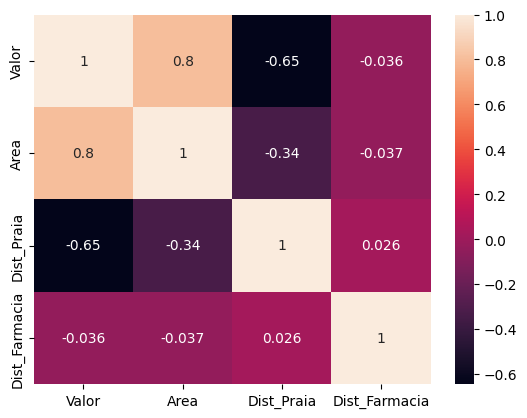

In [54]:
sns.heatmap(dados_log.corr().round(4), annot=True)

Analisando a matriz de correlação acima fica mais tangível o resultado da transformação. O resultado foi muito positivo. A variável Dist_Praia aumentou sua correlação com a variável Valor de forma significativa, mantendo baixas suas correlações com as variáveis Area e Dist Farmacia. Essa última manteve-se com baixa correlação com Valor, mesmo após a transformação logarítmica.

## Criação do modelo de Regressão Linear com statsmodels
<hr>

### Criando os Datasets de Treino e Teste

#### Criando uma Series (pandas) para armazenar as features (X) e a variável target (y)

In [92]:
X = dados_log.drop('Valor', axis=1)
y = dados_log['Valor']

#### Criando os datasets de treino e de teste

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = seed)

### Estimando o modelo com statsmodels

In [94]:
X_train_cte = sm.add_constant(X_train.astype(float))
X_train_cte

,const,Area,Dist_Praia,Dist_Farmacia
4966,1.0,5.164786,0.120592,0.013292
4086,1.0,4.127134,1.964722,0.489272
2881,1.0,4.955827,1.827041,0.662137
1237,1.0,5.135798,0.105337,0.236042
1429,1.0,4.682131,2.099065,0.414566
...,...,...,...,...
4149,1.0,5.010635,0.292654,0.656948
1890,1.0,4.543295,0.637390,0.502179
350,1.0,4.094345,1.973408,0.052389
79,1.0,4.454347,0.782479,0.231968


In [95]:
sm_model = sm.OLS(y_train, X_train_cte, hasconst=True).fit()

#### Avaliando estatísticas do modelo

In [96]:
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Valor   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     4824.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:48:10   Log-Likelihood:                -1788.7
No. Observations:                3500   AIC:                             3585.
Df Residuals:                    3496   BIC:                             3610.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.4069      0.065    144.800

Observando os os valores de P>|t|, notamos que a variável Dist_Farmacia apresenta um valor de 0.516, o que indica que essa variável pode ter pouca significância para o modelo. Se relembrarmos das seções anteriores, notaremos que já foi abordade que essa variável apresentava pouca correlação com a variável target. 

Iremos remover essa variável, criaremos outro modelo e verificaremos novamente o seu desempenho.

### Modificando o modelo e avaliando novamente seu desempenho

#### Criando um novo conjunto de features (X)

In [98]:
X = dados_log.drop(['Valor', 'Dist_Farmacia'], axis=1)

#### Criando os datasets de treino e de teste

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#### Estimando o modelo com o statsmodels

In [101]:
X_train_cte = sm.add_constant(X_train.astype(float))
X_train_cte

,const,Area,Dist_Praia
4966,1.0,5.164786,0.120592
4086,1.0,4.127134,1.964722
2881,1.0,4.955827,1.827041
1237,1.0,5.135798,0.105337
1429,1.0,4.682131,2.099065
...,...,...,...
4149,1.0,5.010635,0.292654
1890,1.0,4.543295,0.637390
350,1.0,4.094345,1.973408
79,1.0,4.454347,0.782479


In [102]:
sm_model = sm.OLS(y_train, X_train_cte, hasconst=True).fit()

#### Avaliando as estatísticas de teste do novo modelo

In [103]:
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Valor   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     7237.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:03:05   Log-Likelihood:                -1788.9
No. Observations:                3500   AIC:                             3584.
Df Residuals:                    3497   BIC:                             3602.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3973      0.063    148.592      0.0

Nota-se que as métricas de R² e R² ajustado manteram-se as mesmas, isso é interessante pois pode poupar tempo e recursos reduzindo a quantidade de variáveis sem que se perca desempenho do modelo.

## Estimando modelo de Regressão Linear com scikit-learn
<hr>

### Criando modelo com LinearRegression

In [107]:
lr_model = LinearRegression()

In [108]:
lr_model.fit(X_train, y_train)

LinearRegression()

### Obtendo o coeficiente de determinação (R²) do modelo estimado com os dados de treino

In [117]:
print('R² de treino = {:.3f}'.format(lr_model.score(X_train,y_train)))

R² de treino = 0.805


R² para os dados de treino manteve-se o mesmo do modelo criado com statsmodels

### Gerando previsões para os dados de teste

In [118]:
y_pred = lr_model.predict(X_test)

### Obtendo o coeficiente de determinação (R²) para as previsões do nosso modelo

In [120]:
print('R² de teste = {:.3f}'.format(metrics.r2_score(y_test, y_pred)))

R² de teste = 0.794


### Obtendo previsões pontuais

#### Dados de entrada

In [126]:
entrada = X_test[0:1]
entrada

,Area,Dist_Praia
789,3.931826,2.158196


#### Gerando previsão pontual

In [132]:
lr_model.predict(entrada)[0].round(3)

12.449

#### Invertendo a transformação para obter a estimativa em R$

In [134]:
np.exp(lr_model.predict(entrada))[0].round(3)

254950.347

### Interpretação dos coeficientes estimados

#### Obtendo o intercepto do modelo

<p style='line-height: 1.5;text-align: justify;'>O <b>intercepto</b> representa o efeito médio em $Y$ (Preço do Imóveis) tendo todas as variáveis explicativas excluídas do modelo. No caso do modelo log-linear este coeficiente deve ser transformado com o uso da função exponencial para ser apresentado em R$.</p>

In [137]:
lr_model.intercept_

9.397305262634019

In [171]:
print('O intercepto representa R$ {:.3f}'.format(np.exp(lr_model.intercept_)))

O intercepto representa R$ 12055.850


#### Obtendo os coeficientes de regressão

<p style='line-height: 1.5; text-align: justify;'>Os <b>coeficientes de regressão</b> $\beta_2$ e $\beta_3$ são conhecidos como <b>coeficientes parciais de regressão</b> ou <b>coeficientes parciais angulares</b>. </p>

<p style='line-height: 1.5; text-align: justify;'>Um aspecto interessante do modelo log-linear, que o tornou muito utilizado nos trabalhos aplicados, é que os coeficientes angulares $\beta_2$ e $\beta_3$ medem as elasticidades de Y em relação a $X_2$ e $X_3$, isto é, a variação percentual de Y correspondente a uma dada variação percentual (pequena) em $X_2$ e $X_3$.</p>

In [140]:
lr_model.coef_

array([ 1.04558496, -0.49093732])

#### Confirmando a ordem das variáveis explicativas no DataFrame

In [144]:
X_train.columns

Index(['Area', 'Dist_Praia'], dtype='object')

#### Criando um DataFrame para armazenar os coeficientes do modelo

In [170]:
coeficientes = pd.DataFrame({'Variável': ['Intercepto', 'B1', 'B2'], 'Valor': [lr_model.intercept_] + list(lr_model.coef_)})
coeficientes

,Variável,Valor
0,Intercepto,9.397305
1,B1,1.045585
2,B2,-0.490937


#### Interpretação dos Coeficientes Estimados

<p style='line-height: 1.5; text-align: justify;'>
<b>Intercepto</b> → Excluindo o efeito das variáveis explicativas ($X_2=X_3=0$) o efeito médio no Preço dos Imóveis seria de <b>R$ 12.055,850</b> (exp[9.397305]).
</p>

<p style='line-height: 1.5;text-align: justify;'>
<b>Área (m²)</b> → Mantendo-se o valor de $X_3$ (Distância até a Praia) constante, um acréscimo de 1% na Área de um imóvel gera, em média, um acréscimo de <b>1.05%</b> no Preço do Imóvel.
</p>

<p style='line-height: 1.5; text-align: justify;'>
<b>Distância até a Praia (km)</b> → Mantendo-se o valor de $X_2$ (Área) constante, um acréscimo de 1% na Distância de um imóvel até a praia gera, em média, um decréscimo de <b>0.49%</b> no Preço do Imóvel.
</p>

### Análises gráficas dos resultados do modelo

#### Gerando as previsões do modelo para os dados de treino

In [172]:
y_train_pred = lr_model.predict(X_train)

#### Gráfico de dispersão entre valor estimado e valor real

<Axes: title={'center': 'Previsão X Real'}, xlabel='log do Preço - Previsão', ylabel='log do Preço - Real'>

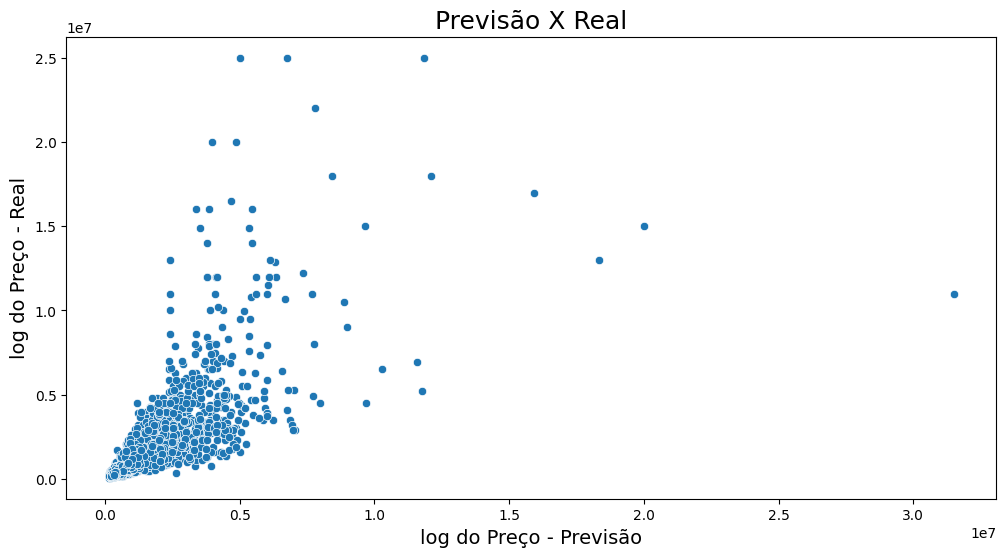

In [173]:
ax = sns.scatterplot(x=np.exp(y_train_pred), y=np.exp(y_train))
ax.figure.set_size_inches(12, 6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('log do Preço - Previsão', fontsize=14)
ax.set_ylabel('log do Preço - Real', fontsize=14)
ax

#### Obtendo os resíduos

In [186]:
residuos = np.exp(y_train) - np.exp(y_train_pred)

#### Plotando a distribuição de frequências dos resíduos

<Axes: title={'center': 'Distribuição de Frequências dos Resíduos'}, xlabel='log do Preço em R$', ylabel='Residuos'>

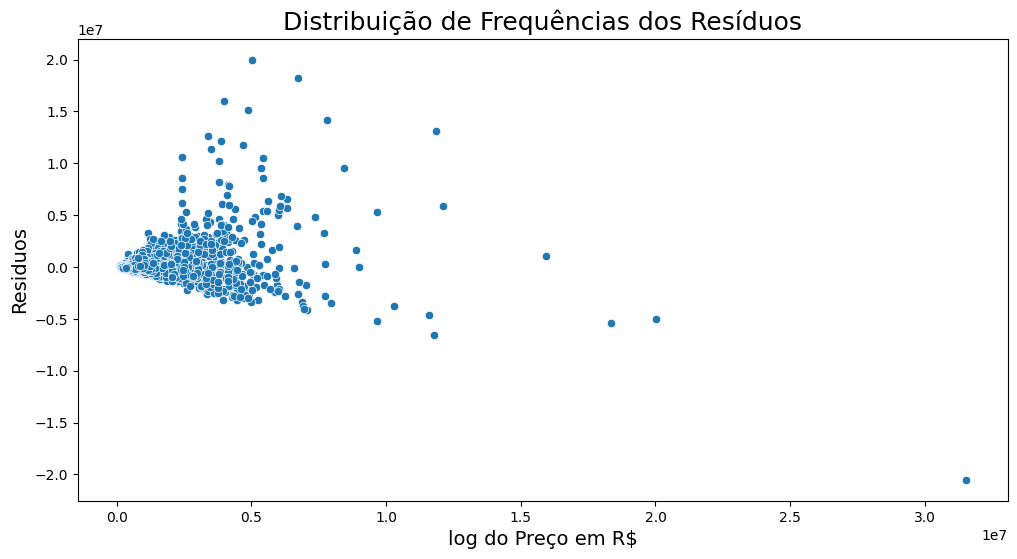

In [187]:
ax = sns.scatterplot(x= np.exp(y_train_pred), y=residuos)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências dos Resíduos', fontsize=18)
ax.set_xlabel('log do Preço em R$', fontsize=14)
ax.set_ylabel('Residuos', fontsize=14)
ax

#### Distribuição de frequências dos resíduos

<Axes: title={'center': 'Distribuição de frequências dos resíduos'}, xlabel='Valor (R$)', ylabel='Quantidade'>

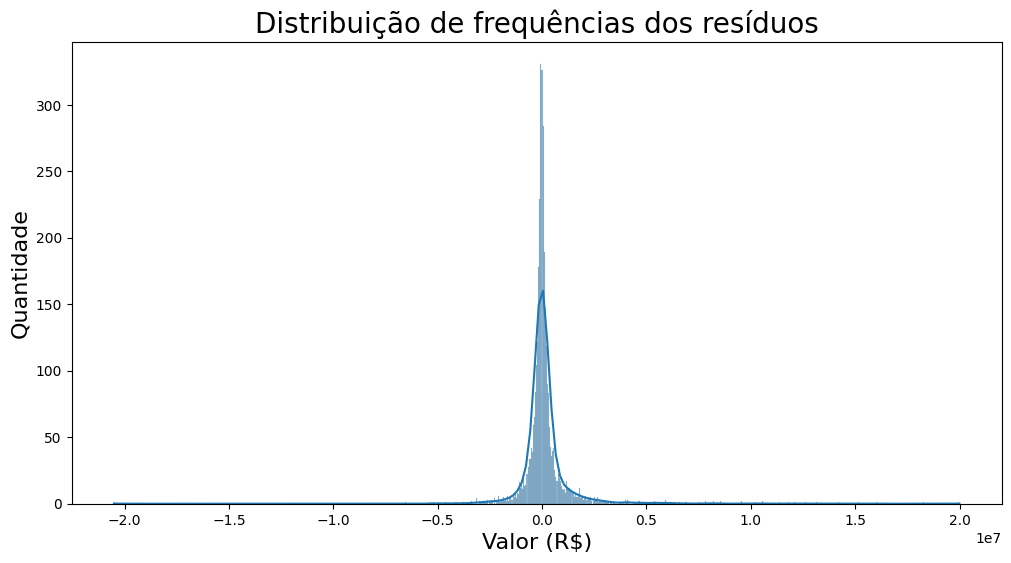

In [193]:
ax = sns.histplot(residuos, kde=True)
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de frequências dos resíduos', fontsize=20)
ax.set_xlabel('Valor (R$)', fontsize=16)
ax.set_ylabel('Quantidade', fontsize=16)
ax

A distribuição dos resíduos, assim como mostrado no gráfico de dispersão, mostra que a maioria dos resíduos se encontra em torno de Zero.